In [2]:
# Install tmdbsimple (only need to run once)
# !pip install tmdbsimple
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, json, time
from tqdm.notebook import tqdm_notebook

In [3]:
# Load TMDB API Key & Add to tmdbsimple
with open('.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()

dict_keys(['client-id', 'api-key'])

In [4]:
# Importing tmdbsimple and setting the API_KEY
import tmdbsimple as tmdb
tmdb.API_KEY =  login['api-key']

In [5]:
# Designate a Folder

# Create the folder for saving files (if it doesn't exist)
FOLDER = "MovieData/"
os.makedirs(FOLDER, exist_ok=True)

# Show the list of files included in the folder
sorted(os.listdir(FOLDER))
['.DS_Store', '.ipynb_checkpoints', 'title-basics.csv']

# Define Your Functions
def get_movie_with_rating(movie_id):
    # Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    
    # save the .info .releases dictionaries
    movie_info = movie.info()
    releases = movie.releases()
    
    # Loop through countries in releases
    for c in releases['countries']:
        # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
            ## save a "certification" key in the info dict with the certification
            movie_info['certification'] = c['certification']
    return movie_info


def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

### Load in the cleaned Title Basics (from part 1)

In [6]:
basics = pd.read_csv('Data/basics.csv')
basics

# Set the year to filter for
YEARS_TO_GET = [2001,2002]

# Create an empty list for saving errors
errors = []

In [7]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    
    # Define the JSON file to store results for the year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'

    # Check if the JSON file exists
    file_exists = os.path.isfile(JSON_FILE)

    # If it does not exist: create it
    if file_exists == False:
        print(f"Creating {JSON_FILE} for API results for year={YEAR}.")
    
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)

    # If it exists, print a message
    else:
        print(f'The file {JSON_FILE} already exists.')

    # Filtering for movies from selected startYear
    df = basics.loc[basics['startYear']==YEAR].copy()

    # saving movie ids to list
    movie_ids = df['tconst']

    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
    previous_df

    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    # Loop through movie_ids_to_get with a tqdm progress bar
    for movie_id in tqdm_notebook(movie_ids_to_get, f"Movies from {YEAR}"):
    
        # Attempt to retrieve then data for the movie id
        try:
            temp = get_movie_with_rating(movie_id)  # This uses your pre-made function
            
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
    
        # If it fails,  make a dict with just the id and None for certification.
        except Exception as e:
            errors.append([movie_id, e])
        
    # Save the final results to a csv.gz file
    final_year_df = pd.read_json(JSON_FILE)
    csv_fname = f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz"
    final_year_df.to_csv(csv_fname, compression="gzip", index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

The file MovieData/tmdb_api_results_2001.json already exists.


Movies from 2001:   0%|          | 0/224 [00:00<?, ?it/s]

The file MovieData/tmdb_api_results_2002.json already exists.


Movies from 2002:   0%|          | 0/280 [00:00<?, ?it/s]

In [8]:
print(f"- Total errors: {len(errors)}")

- Total errors: 504


In [9]:
final_year_df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0096056,0.0,/95U3MUDXu4xSCmVLtWgargRipDi.jpg,None,0.0,"[{'id': 18, 'name': 'Drama'}]",,109809.0,en,Crime and Punishment,...,0.0,126.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Crime and Punishment,0.0,5.333,12.0,NaN
2,tt0118926,0.0,/qR3Dk3ctnrrxkAI6I472RhamIbu.jpg,None,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",,20689.0,en,The Dancer Upstairs,...,5227348.0,132.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"An honest man caught in a world of intrigue, p...",The Dancer Upstairs,0.0,6.200,51.0,R
3,tt0119980,0.0,None,None,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",,563364.0,en,Random Shooting in LA,...,0.0,91.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Random Shooting in LA,0.0,0.000,0.0,
4,tt0120679,0.0,/s04Ds4xbJU7DzeGVyamccH4LoxF.jpg,None,12000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.miramax.com/movie/frida,1360.0,en,Frida,...,56298474.0,123.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,Prepare to be seduced.,Frida,0.0,7.428,1905.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,tt6449044,0.0,/a9pkw8stijESGx1flSGPqcXLkHu.jpg,"{'id': 957260, 'name': 'The Conman Collection'...",0.0,"[{'id': 35, 'name': 'Comedy'}]",,314105.0,cn,賭俠2002,...,0.0,97.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,,The Conman 2002,0.0,4.300,3.0,NaN
1289,tt6694126,0.0,/sXjVpTZyDvwzPVZve3AmyCUBeHk.jpg,None,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",,819174.0,fa,عروس خوش‌قدم,...,0.0,101.0,"[{'english_name': 'Persian', 'iso_639_1': 'fa'...",Released,,The Lucky Bride,0.0,8.000,1.0,NaN
1290,tt8302928,0.0,None,None,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",,866533.0,el,Movie Toons: Treasure Island,...,0.0,0.0,[],Released,,Movie Toons: Treasure Island,0.0,0.000,0.0,
1291,tt8474326,0.0,None,None,0.0,[],,292027.0,en,Skin Eating Jungle Vampires,...,0.0,0.0,[],Released,,Skin Eating Jungle Vampires,0.0,0.000,0.0,


### Exploratory Data Analysis
Once you have retrieved and saved the final results to separate .csv.gz files:

In [10]:
# Load and Combine the final API data into 1 DataFrame
import glob
tmdb_files = sorted(glob.glob("MovieData/final_tmdb_data*.csv.gz"))
tmdb_files

['MovieData\\final_tmdb_data_2001.csv.gz',
 'MovieData\\final_tmdb_data_2002.csv.gz']

In [11]:
# Use read_csv in a list comprehension and combine with concat to load all files
df = pd.concat([pd.read_csv(f) for f in tmdb_files] )
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.327,1233.0,PG-13
2,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.000,3.0,NaN
3,tt0116916,0.0,/rFpHBidSlhjflmnLu7BZilyKeQR.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,73549.0,en,The Dark Mist,...,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Dark Mist,0.0,3.500,2.0,PG
4,tt0118589,0.0,/9NZAirJahVilTiDNCHLFcdkwkiy.jpg,NaN,22000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696.0,en,Glitter,...,5271666.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"In music she found her dream, her love, herself.",Glitter,0.0,4.405,132.0,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,tt6449044,0.0,/a9pkw8stijESGx1flSGPqcXLkHu.jpg,"{'id': 957260, 'name': 'The Conman Collection'...",0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,314105.0,cn,賭俠2002,...,0.0,97.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,The Conman 2002,0.0,4.300,3.0,NaN
1289,tt6694126,0.0,/sXjVpTZyDvwzPVZve3AmyCUBeHk.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,819174.0,fa,عروس خوش‌قدم,...,0.0,101.0,"[{'english_name': 'Persian', 'iso_639_1': 'fa'...",Released,NaN,The Lucky Bride,0.0,8.000,1.0,NaN
1290,tt8302928,0.0,NaN,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,866533.0,el,Movie Toons: Treasure Island,...,0.0,0.0,[],Released,NaN,Movie Toons: Treasure Island,0.0,0.000,0.0,NaN
1291,tt8474326,0.0,NaN,NaN,0.0,[],NaN,292027.0,en,Skin Eating Jungle Vampires,...,0.0,0.0,[],Released,NaN,Skin Eating Jungle Vampires,0.0,0.000,0.0,NaN


In [12]:
# save copy of df to csv
df.to_csv('final_tmdb_data.csv.gz')

### Create Visualizations to Answer the Following Questions:

#### How many movies had at least some valid financial information (values > 0 for budget OR revenue)?

Please exclude any movies with 0's for budget AND revenue from the remaining visualizations.

In [13]:
# movies with budget !=0
budget_not_zero = df['budget'] != 0

budget_not_zero.value_counts()

False    2027
True      619
Name: budget, dtype: int64

In [14]:
# movies with revenue !=0
revenue_not_zero = df['revenue'] != 0

revenue_not_zero.value_counts()

False    2126
True      520
Name: revenue, dtype: int64

In [15]:
# df where both budget and revenue =! 0

df_both = pd.concat([df['revenue'], df['budget']])
not_zero = df_both != 0
not_zero.value_counts()

False    4153
True     1139
dtype: int64

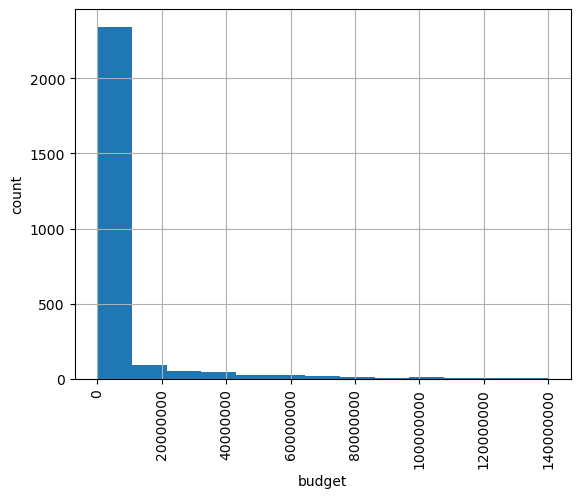

In [16]:
ax=df['budget'].hist(bins='auto')
ax.ticklabel_format(style='plain')
ax.tick_params(axis='x', rotation= 90)
ax.set_xlabel('budget')
ax.set_ylabel('count');

#### 619 movies had a budget greater than 0.

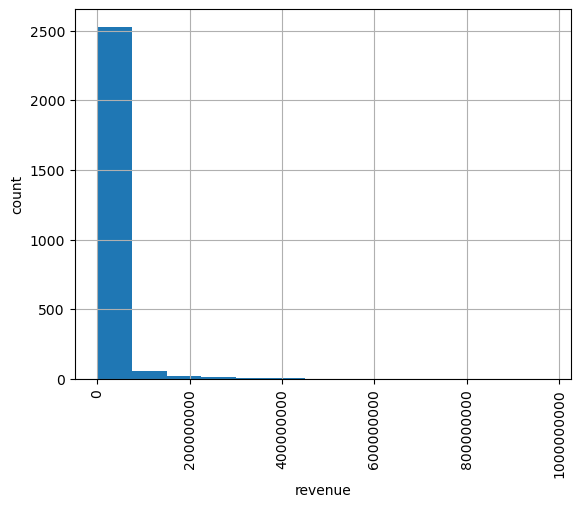

In [17]:
ax=df['revenue'].hist(bins='auto')
ax.ticklabel_format(style='plain')
ax.tick_params(axis='x', rotation= 90)
ax.set_xlabel('revenue')
ax.set_ylabel('count');

#### 520 movies had a revenue greater than 0.

#### How many movies are there in each of the certification categories (G/PG/PG-13/R)?

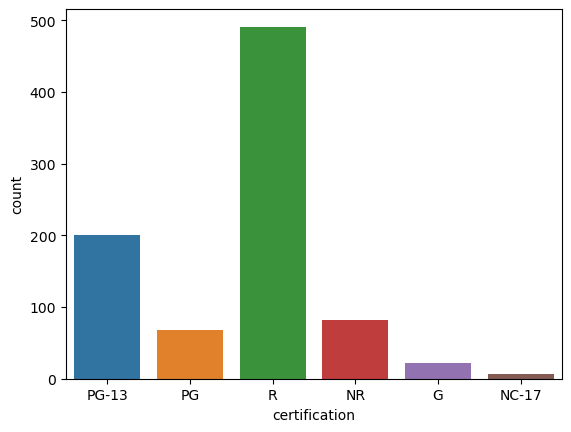

In [18]:
ax = sns.countplot(data=df, x='certification')

In [19]:
df['certification'].value_counts()

R        491
PG-13    201
NR        82
PG        68
G         22
NC-17      6
Name: certification, dtype: int64

#### What is the average revenue per certification category?

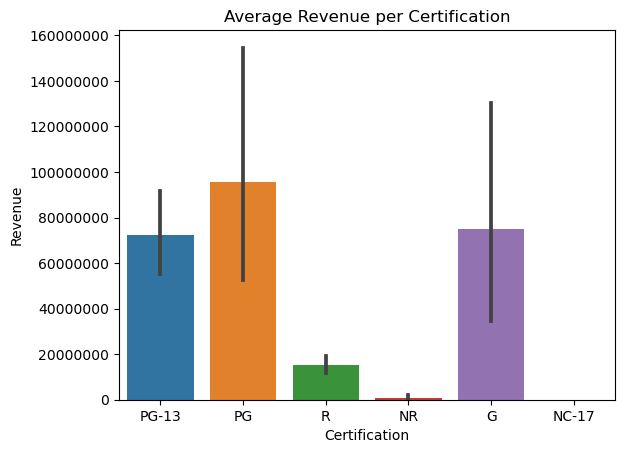

In [20]:
ax = sns.barplot(data=df, x='certification', y='revenue')
ax.set_title('Average Revenue per Certification')
ax.set_xlabel('Certification');
ax.set_ylabel('Revenue')
plt.ticklabel_format(style='plain', axis='y');

#### What is the average budget per certification category?

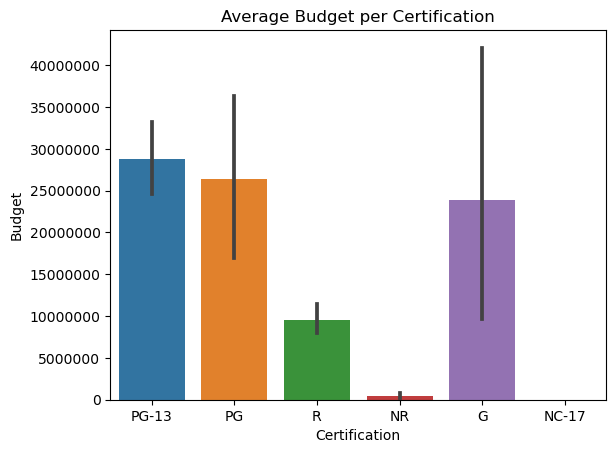

In [21]:
ax = sns.barplot(data=df, x='certification', y='budget')
ax.set_title('Average Budget per Certification')
plt.ticklabel_format(style='plain', axis='y')
ax.set_xlabel('Certification');
ax.set_ylabel('Budget');